In [1]:
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# 转换时间格式，将字符串转换成 datatime 格式
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# 加载 mat 文件
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# 提取锂电池容量
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# 获取锂电池充电或放电时的测试数据
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [3]:
Battary_list = ['B0005', 'B0006', 'B0007', 'B0018']

Battery = {}
for name in Battary_list:
    print('Load Dataset ' + name + '.mat ...')
    path = name + '.mat'
    data = loadMat(path)
    Battery[name] = getBatteryCapacity(data)              # 放电时的容量数据

Load Dataset B0005.mat ...
Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


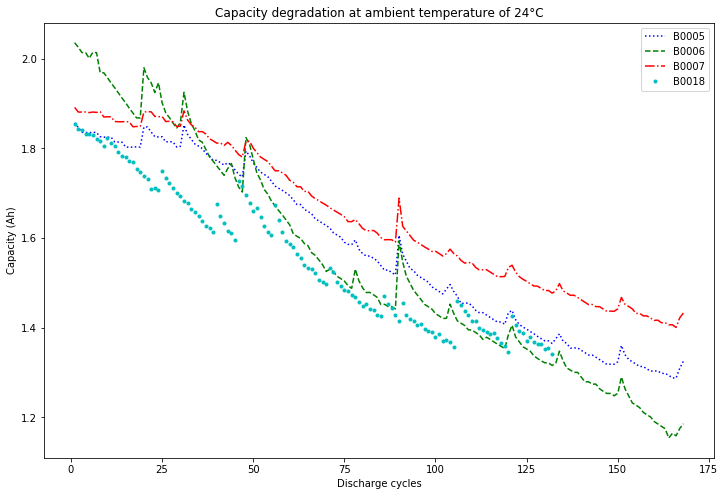

In [4]:
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c:']
c = 0
for name,color in zip(Battary_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

In [5]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


def split_dataset(data_sequence, train_ratio=0.7, capacity_threshold=0.0):
    if capacity_threshold > 0:
        max_capacity = max(data_sequence)
        capacity = max_capacity * capacity_threshold
        point=[i for i in range(len(data_sequence)) if data_sequence[i] < capacity]
    else:
        point=int(len(data_sequence) * train_ratio)
    train_data, test_data=data_sequence[:point], data_sequence[point:]
    return train_data, test_data


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = 0, 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

三个锂电池的全部数据加一个锂电池的部分数据（train_ratio）为训练集，该锂电池的剩余数据为测试集

In [6]:
def get_train_test(data_dict, name, window_size=8):
    train_data, test_data = split_dataset(data_sequence=data_dict[name][1], train_ratio=0.5, capacity_threshold=0.0)
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)

In [7]:
window_size = 8
name = Battary_list[0] # 'B0005'
train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)

In [8]:
class Net(nn.Module):
    def __init__(self, feature_size=8, hidden_size=[32, 16, 8]):
        super(Net, self).__init__()
        self.feature_size, self.hidden_size = feature_size, hidden_size
        self.layer0 = nn.Linear(self.feature_size, self.hidden_size[0])
        self.layers = [nn.Sequential(nn.Linear(self.hidden_size[i], self.hidden_size[i+1]), nn.ReLU()) 
                       for i in range(len(self.hidden_size) - 1)]
        self.linear = nn.Linear(self.hidden_size[-1], 1)
 
    def forward(self, x):
        out = self.layer0(x)
        for layer in self.layers:
            out = layer(out)
        out = self.linear(out) 
        return out

In [9]:
# Hyper parameter
EPOCH = 1000
LR = 0.1    # learning rate
feature_size = window_size
hidden_size = [16, 8]
weight_decay = 0.0
seed = 0

train_size = len(train_x)
print('sample size: {}'.format(train_size))
mae_list, rmse_list, re_list = [], [], []
for seed in range(10):
    setup_seed(seed)
    model = Net(feature_size=feature_size, hidden_size=hidden_size)
    if torch.cuda.is_available():
        model = model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    test_x = train_data.copy()
    prediction_list, loss_list, y_ = [], [0], []
    Rated_Capacity = 2.0
    for epoch in range(EPOCH):
        prediction=[]
        X = np.reshape(train_x/Rated_Capacity,(-1, feature_size)).astype(np.float32)
        y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)

        X, y = torch.from_numpy(X), torch.from_numpy(y)
        output= model(X)
        loss = criterion(output, y)
        optimizer.zero_grad()              # clear gradients for this training step
        loss.backward()                    # backpropagation, compute gradients
        optimizer.step()                   # apply gradients

        prediction.append(output[:,0].data.numpy() * Rated_Capacity) #训练集模型预测
        if (epoch + 1)%100 == 0:
            test_x = train_data.copy() #每100次重新预测一次
            point_list = []
            while (len(test_x) - len(train_data)) < len(test_data):
                x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, feature_size)).astype(np.float32)
                x = torch.from_numpy(x)
                pred = model(x) # 测试集 模型预测#pred shape为(batch_size=1, feature_size=1)
                next_point = pred.data.numpy()[0,0] * Rated_Capacity
                test_x.append(next_point)#测试值加入原来序列用来继续预测下一个点
                point_list.append(next_point)#保存输出序列最后一个点的预测值
            y_.append(point_list)#保存本次预测所有的预测值
            loss_list.append(loss)
            mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
            re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
            print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, mae, rmse, re))
        if (len(loss_list) > 1) and (abs(loss_list[-2] - loss_list[-1]) < 1e-5):
            break

        prediction_list.append(np.reshape(np.array(prediction),(-1)))

    mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
    mae_list.append(mae)
    rmse_list.append(rmse)
    re_list.append(re)
    print('------------------------------------------------------------------')
print('MAE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(mae_list)), np.std(np.array(mae_list))))
print('RMSE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(rmse_list)), np.std(np.array(rmse_list))))
print('RE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(re_list)), np.std(np.array(re_list))))

sample size: 520
epoch:99 | loss:0.0016 | MAE:0.1711 | RMSE:0.1889 | RE:1.0000
epoch:199 | loss:0.0002 | MAE:0.0482 | RMSE:0.0546 | RE:0.6410
epoch:299 | loss:0.0002 | MAE:0.0133 | RMSE:0.0176 | RE:0.0513
epoch:399 | loss:0.0002 | MAE:0.0133 | RMSE:0.0177 | RE:0.0513
------------------------------------------------------------------
epoch:99 | loss:0.0004 | MAE:0.1179 | RMSE:0.1342 | RE:1.0000
epoch:199 | loss:0.0002 | MAE:0.0147 | RMSE:0.0182 | RE:0.1026
epoch:299 | loss:0.0002 | MAE:0.0135 | RMSE:0.0178 | RE:0.0513
------------------------------------------------------------------
epoch:99 | loss:0.0015 | MAE:0.1737 | RMSE:0.1913 | RE:1.0000
epoch:199 | loss:0.0001 | MAE:0.0218 | RMSE:0.0248 | RE:0.2051
epoch:299 | loss:0.0001 | MAE:0.0135 | RMSE:0.0180 | RE:0.0513
------------------------------------------------------------------
epoch:99 | loss:0.0006 | MAE:0.1422 | RMSE:0.1599 | RE:1.0000
epoch:199 | loss:0.0002 | MAE:0.0135 | RMSE:0.0179 | RE:0.0513
epoch:299 | loss:0.0001 | MAE:

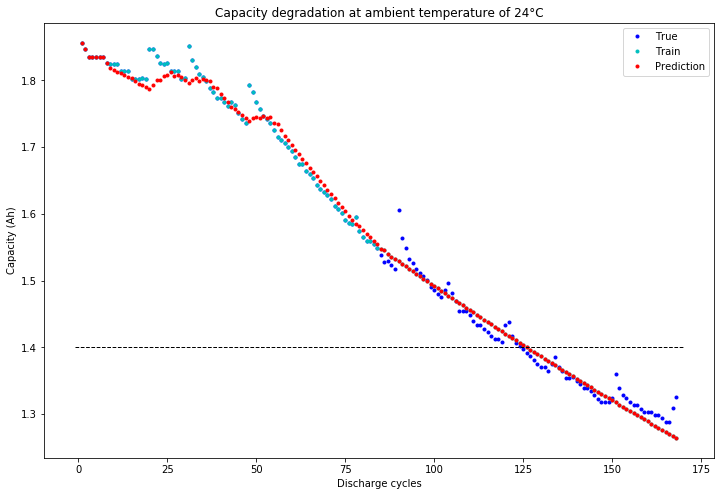

In [10]:
aa = train_data[:window_size].copy() # 第一个输入序列
[aa.append(a) for a in prediction_list[-1][:len(train_data) - window_size]] # 训练集的模型预测值
[aa.append(a) for a in y_[-1]] # 测试集预测结果


battery = Battery[name]
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(battery[0], battery[1], 'b.', label='True')
ax.plot(battery[0], test_x, 'c.', label='Train')
ax.plot(battery[0], aa, 'r.', label='Prediction')
plt.plot([-1,170],[Rated_Capacity*0.7, Rated_Capacity*0.7], c='black', lw=1, ls='--')  # 临界点直线
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()